In [120]:
import pandas as pd
import numpy as np
import os
from functools import reduce
import matplotlib.pyplot as plt

In [ ]:
# Overall steps:

# 1. Get all tables into the same format (Rows: Area, Columns: Feature by year 2010-2023)

# 2. Limit to ~10 most usable categories at first
# 3. Drop Åland, impute missing years/values
# 4. Apply simple ML algorithm (linear regression) to predict average age based on factors like:
# 5. Age, sex, daily smoking, binge drinking, obesity, physical activity, happiness, disposable income, access to healthcare, mental strain, etc.

### Data Loading

In [2]:
data_dir = "regional_data"
subdirs = ["thl", "tilastokeskus"]

#### Life Expectancy

In [3]:
# Load the data
life_expectancy = pd.read_csv(data_dir + '/thl/life_expectancy.csv', sep=';', index_col=False)

# columns value and value2 are always equal
life_expectancy = life_expectancy.drop(columns=['indicator', 'indicator_id', 'region_id', 'value2'])
life_expectancy_by_region_and_sex = life_expectancy.groupby(['region', 'sex'])['value'].mean().reset_index()

# Male, female and combined life expectancy per region
print(life_expectancy_by_region_and_sex.head(15))

                  region       sex      value
0        Central Finland  combined  80.900000
1        Central Finland    female  83.857143
2        Central Finland      male  77.978571
3   Central Ostrobothnia  combined  81.785714
4   Central Ostrobothnia    female  84.428571
5   Central Ostrobothnia      male  79.128571
6                 Kainuu  combined  79.764286
7                 Kainuu    female  83.321429
8                 Kainuu      male  76.478571
9             Kanta-Häme  combined  81.035714
10            Kanta-Häme    female  83.935714
11            Kanta-Häme      male  78.121429
12           Kymenlaakso  combined  79.950000
13           Kymenlaakso    female  83.257143
14           Kymenlaakso      male  76.750000


In [80]:
# Load the data
df = pd.read_csv(data_dir + '/tilastokeskus/age_sex_rural_urban.csv', sep=';', index_col=False)
df = df.rename(columns={"Area": "region"})
df = df.melt(id_vars=["region"], var_name="year", value_name="value")
df[["indicator", "year"]] = df["year"].str.rsplit(" ", n=1, expand=True)
dfs = {indicator: group for indicator, group in df.groupby("indicator")}
dfs["Average age, both sexes"]

,region,year,value,indicator
0,MK01 Uusimaa,2010,39.4,"Average age, both sexes"
1,MK02 Southwest Finland,2010,42.1,"Average age, both sexes"
2,MK04 Satakunta,2010,43.9,"Average age, both sexes"
3,MK05 Kanta-Häme,2010,42.5,"Average age, both sexes"
4,MK06 Pirkanmaa,2010,41.2,"Average age, both sexes"
...,...,...,...,...
280,MK16 Central Ostrobothnia,2024,43.6,"Average age, both sexes"
281,MK17 North Ostrobothnia,2024,41.8,"Average age, both sexes"
282,MK18 Kainuu,2024,48.2,"Average age, both sexes"
283,MK19 Lapland,2024,46.1,"Average age, both sexes"


In [96]:
# List for storing the dataframes and the feature columns
frames = []
features = []

for subdir in os.listdir(data_dir):
    if subdir in subdirs:
        path = data_dir + "/" + subdir
        
        for file in os.listdir(path):
            filename = os.fsdecode(file)
            filepath = path + "/" + filename
            print(f"Processing file: {filename} from: {path}")
            df = pd.read_csv(filepath, sep=';', index_col=False)
            
            if subdir == "thl":
                # Get the name of the measured feature
                name = filename.split(".")[0]
                features.append(name)

                # Get a brief description
                description = df["indicator"][0]

                # Drop unnecessary columns
                df = df.drop(columns=['indicator', 'indicator_id', 'region_id', 'sex'])

                # Rename value column to the name of what was measured
                df = df.rename(columns={"value": name})

                # Group the data by region
                df_mean_by_region = df.groupby(['region'])[name].mean().reset_index()

                frames.append(df_mean_by_region)

                print(f"Data description: {description}\n")

            elif subdir == "tilastokeskus":
                df = df.rename(columns={"Area": "region"})
                df = df.melt(id_vars=["region"], var_name="year", value_name="value")

                df[["indicator", "year"]] = df["year"].str.rsplit(" ", n=1, expand=True)
                dfs = {indicator: group for indicator, group in df.groupby("indicator")}

                # Process separate dataframes per file based on the feature
                for name, df in dfs.items():
                    # Rename the value column to the measured feature
                    df.rename(columns={"value": name}, inplace=True)
                    df["region"] = df["region"].str.split(" ", n=1).str[1]

                    # Group the data by region
                    df_mean_by_region = df.groupby(['region'])[name].mean().reset_index()
                    features.append(name)
                    frames.append(df_mean_by_region)

            print(f"{df_mean_by_region.tail()}\n")
            print(f"================================\n")

# Combine all the dataframes
df = reduce(lambda x, y: pd.merge(x, y, on = 'region'), frames)

Processing file: alcohol_sales.csv from: regional_data/thl
Data description: Sale of alcoholic beverages per capita, as litres of pure alcohol

                region  alcohol_sales
14  South Ostrobothnia       5.973333
15          South Savo       8.846667
16   Southwest Finland       7.186667
17             Uusimaa       6.786667
18               Åland       5.546667


Processing file: binge_drinking.csv from: regional_data/thl
Data description: Persons who engage in binge drinking (AUDIT-1k) (%)

                region  binge_drinking
14  South Ostrobothnia        7.871429
15          South Savo        9.628571
16   Southwest Finland       10.757143
17             Uusimaa       10.200000
18               Åland        7.400000


Processing file: culture_promotion.csv from: regional_data/thl
Data description: Promotion of culture in municipalities - TEA, score

                region  culture_promotion
13       South Karelia          66.333333
14  South Ostrobothnia          60.333333

C:\Users\tomco\AppData\Local\Temp\ipykernel_14268\3640228914.py:13: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv(filepath, sep=';', index_col=False)


In [97]:
df

,region,alcohol_sales,binge_drinking,culture_promotion,daily_smokers,disability_ratio,elder_care_per_100k,fees_hampered_care,health_workers_per_10k,incidence_disability_pension,...,"Share of persons aged 15 or over with at least upper secondary qualification, %","Share of persons aged 15 or over with tertiary level qualification, %","Share of persons aged 15 or over without upper secondary qualification, %, %",Population 31 Dec Employed,Population 31 Dec Other persons outside the labour force,Population 31 Dec Pensioners,Population 31 Dec Unemployed,"1. EARNED INCOME, mean","Disposable cash income, median","Dwelling population, persons"
0,Central Finland,7.133333,10.242857,62.000000,10.742857,7.933333,2675.500000,28.050,77.091667,5.100000,...,73.180000,29.426667,26.820000,107775.785714,7456.071429,72035.642857,18354.642857,31991.857143,35212.071429,2.676854e+05
1,Central Ostrobothnia,6.373333,8.828571,68.333333,13.128571,7.960000,3075.855556,27.625,108.225000,5.286667,...,69.326667,24.973333,30.673333,27986.714286,1819.642857,17845.642857,2898.642857,35204.857143,40416.357143,6.730750e+04
2,Kainuu,8.120000,10.128571,63.000000,13.242857,11.100000,4083.455556,34.875,95.681250,6.960000,...,70.820000,24.286667,29.180000,27827.214286,1878.142857,24286.428571,4592.428571,28768.000000,34793.928571,7.264743e+04
3,Kanta-Häme,7.406667,8.628571,61.333333,13.171429,7.400000,2448.977778,27.325,69.025000,5.280000,...,70.540000,27.773333,29.460000,72219.000000,4846.500000,48239.357143,8602.642857,35481.428571,37819.428571,1.694956e+05
4,Kymenlaakso,7.733333,10.957143,73.000000,14.185714,9.153333,2843.455556,30.825,69.860417,6.013333,...,69.973333,25.446667,30.026667,64166.071429,5255.000000,53454.285714,11196.214286,31341.357143,35425.785714,1.643861e+05
5,Lapland,10.006667,9.957143,67.666667,15.028571,9.886667,3314.666667,31.275,89.920833,6.613333,...,72.220000,26.120000,27.780000,70601.714286,4707.928571,52500.714286,11199.142857,31667.214286,36148.214286,1.747509e+05
6,North Karelia,7.040000,8.728571,54.666667,12.557143,9.640000,3244.611111,32.950,86.381250,5.693333,...,71.753333,25.500000,28.246667,61970.714286,4688.571429,50605.857143,11491.642857,27273.428571,32868.571429,1.629385e+05
7,North Ostrobothnia,6.620000,10.800000,67.000000,11.928571,9.026667,2861.066667,29.325,98.487500,6.340000,...,73.840000,29.226667,26.160000,163218.071429,10743.714286,94965.285714,24071.642857,35909.642857,38008.071429,4.036331e+05
8,North Savo,7.600000,9.928571,68.666667,12.528571,10.566667,3094.122222,27.875,110.533333,6.926667,...,72.533333,27.453333,27.466667,99831.071429,6377.714286,74246.285714,14075.428571,31249.071429,35003.642857,2.458280e+05
9,Ostrobothnia,5.446667,8.142857,56.000000,9.842857,6.066667,2317.266667,26.150,94.268750,4.113333,...,70.713333,30.040000,29.286667,77305.071429,4661.785714,43923.500000,6182.071429,38101.928571,40443.571429,1.729186e+05


### Linear correlations

In [98]:
target_variable = "life_expectancy"

corr = df.corr(numeric_only=True)[target_variable].sort_values(ascending=False)
print(corr)

life_expectancy                                                                    1.000000
Disposable cash income,  median                                                    0.793385
overcrowded_living                                                                 0.732492
1. EARNED INCOME, mean                                                             0.674931
Share of persons aged 15 or over with tertiary level qualification, %              0.518714
Population 31 Dec Employed                                                         0.285448
Dwelling population, persons                                                       0.282536
health_workers_per_10k                                                             0.260693
Population 31 Dec Pensioners                                                       0.256297
Population 31 Dec Other persons outside the labour force                           0.254923
Population density                                                              

### Input features and target, Train-test split

In [99]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

y = df[target_variable]
X = df[features].drop(columns=[target_variable])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [100]:
X

,alcohol_sales,binge_drinking,culture_promotion,daily_smokers,disability_ratio,elder_care_per_100k,fees_hampered_care,health_workers_per_10k,incidence_disability_pension,insufficient_medical_services,...,"Share of persons aged 15 or over with at least upper secondary qualification, %","Share of persons aged 15 or over with tertiary level qualification, %","Share of persons aged 15 or over without upper secondary qualification, %, %",Population 31 Dec Employed,Population 31 Dec Other persons outside the labour force,Population 31 Dec Pensioners,Population 31 Dec Unemployed,"1. EARNED INCOME, mean","Disposable cash income, median","Dwelling population, persons"
0,7.133333,10.242857,62.000000,10.742857,7.933333,2675.500000,28.050,77.091667,5.100000,20.550,...,73.180000,29.426667,26.820000,107775.785714,7456.071429,72035.642857,18354.642857,31991.857143,35212.071429,2.676854e+05
1,6.373333,8.828571,68.333333,13.128571,7.960000,3075.855556,27.625,108.225000,5.286667,18.150,...,69.326667,24.973333,30.673333,27986.714286,1819.642857,17845.642857,2898.642857,35204.857143,40416.357143,6.730750e+04
2,8.120000,10.128571,63.000000,13.242857,11.100000,4083.455556,34.875,95.681250,6.960000,24.975,...,70.820000,24.286667,29.180000,27827.214286,1878.142857,24286.428571,4592.428571,28768.000000,34793.928571,7.264743e+04
3,7.406667,8.628571,61.333333,13.171429,7.400000,2448.977778,27.325,69.025000,5.280000,17.025,...,70.540000,27.773333,29.460000,72219.000000,4846.500000,48239.357143,8602.642857,35481.428571,37819.428571,1.694956e+05
4,7.733333,10.957143,73.000000,14.185714,9.153333,2843.455556,30.825,69.860417,6.013333,20.525,...,69.973333,25.446667,30.026667,64166.071429,5255.000000,53454.285714,11196.214286,31341.357143,35425.785714,1.643861e+05
5,10.006667,9.957143,67.666667,15.028571,9.886667,3314.666667,31.275,89.920833,6.613333,20.025,...,72.220000,26.120000,27.780000,70601.714286,4707.928571,52500.714286,11199.142857,31667.214286,36148.214286,1.747509e+05
6,7.040000,8.728571,54.666667,12.557143,9.640000,3244.611111,32.950,86.381250,5.693333,27.225,...,71.753333,25.500000,28.246667,61970.714286,4688.571429,50605.857143,11491.642857,27273.428571,32868.571429,1.629385e+05
7,6.620000,10.800000,67.000000,11.928571,9.026667,2861.066667,29.325,98.487500,6.340000,21.500,...,73.840000,29.226667,26.160000,163218.071429,10743.714286,94965.285714,24071.642857,35909.642857,38008.071429,4.036331e+05
8,7.600000,9.928571,68.666667,12.528571,10.566667,3094.122222,27.875,110.533333,6.926667,18.450,...,72.533333,27.453333,27.466667,99831.071429,6377.714286,74246.285714,14075.428571,31249.071429,35003.642857,2.458280e+05
9,5.446667,8.142857,56.000000,9.842857,6.066667,2317.266667,26.150,94.268750,4.113333,21.525,...,70.713333,30.040000,29.286667,77305.071429,4661.785714,43923.500000,6182.071429,38101.928571,40443.571429,1.729186e+05


### Testing Random Forest Regression

In [101]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Get feature importances
importances = pd.Series(model.feature_importances_, index=X.columns)
print(importances.sort_values(ascending=False))

# Test diagnostics
y_pred = model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))


Disposable cash income,  median                                                    0.135597
Average age, women                                                                 0.128269
1. EARNED INCOME, mean                                                             0.086980
Average age, men                                                                   0.077666
Average age, both sexes                                                            0.073995
alcohol_sales                                                                      0.067773
work_until_retired                                                                 0.053796
overcrowded_living                                                                 0.053216
daily_smokers                                                                      0.032831
Population 31 Dec Employed                                                         0.026552
Share of persons aged 15 or over with tertiary level qualification, %           

### Testing a simple neural network

In [122]:
# Hyperparameters
input_dim = X_train.shape[1]
n_neurons = 32
epochs = 50 

# Input layer
model = keras.Sequential([
      layers.Dense(n_neurons, input_dim=input_dim, kernel_initializer='normal', activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(128, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(32, activation='relu'),
      layers.Dense(1, kernel_initializer='normal')
  ])

# Compile and train the model
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.001))
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, verbose=1)

Epoch 1/50


d:\Various Things\Data Science Study\Introduction to Data Science\mini_project\healthy-life-predict\.venv\lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 628555.6875 - val_loss: 29624.4414
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 125723.2969 - val_loss: 26205.1797
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 125375.0391 - val_loss: 3492.3650
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 11740.4902 - val_loss: 7586.3110
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 18707.5371 - val_loss: 19442.4883
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 60283.7109 - val_loss: 14210.1670
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 32206.7480 - val_loss: 2474.4941
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 2567.9121 - val_loss: 1024.0155
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 24863.6855 - val_loss: 2096.8828
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 29676.4668 - val_loss: 80.8652
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 4504.6436 - val_loss: 2621.3938
Epoch 12/50
1/1 ━━

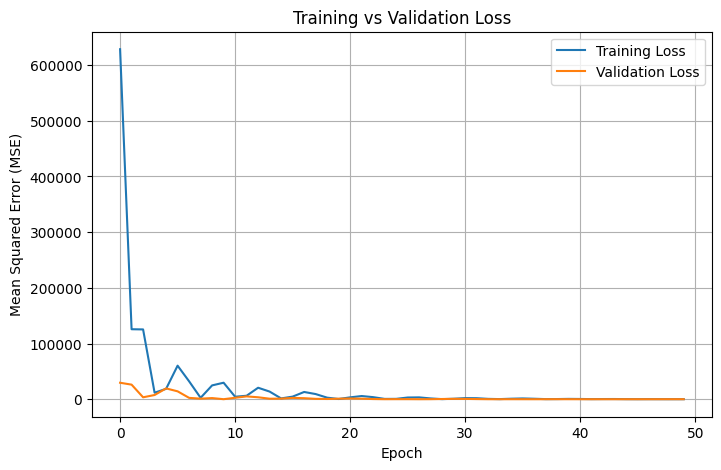

In [123]:
# Plot training & validation loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)
plt.show()

### Test predictions

In [134]:
test_data = pd.DataFrame([{
    "alcohol_sales": 5,
    "binge_drinking": 10,
    "culture_promotion": 100,
    "daily_smokers": 15,
    "Disposable cash income,  median": 35300,
    # "disability_ratio": 10,
    # "elder_care_per_100k": 2675,
    # "fees_hampered_care": 28,
    # "health_workers_per_10k": 110,
    # "incidence_disability_pension": 5,
    # "insufficient_medical_services": 18,
    # "mental_health": 128,
    # "obesity_rate": 22,
    # "overcrowded_living": 7,
    # "percentage_happy": 60,
    # "physical_activity": 22,
    # "regular_sports_events": 75,
    # "severe_mental_strain": 12,
    # "work_until_retired": 27,
}])

# Fill in all missing columns with mean values from the dataset
for col in X.columns:
    if col not in test_data.columns:
        test_data[col] = X[col].mean()

# Reorder columns to match the data
test_data = test_data[X.columns]

test_prediction = model.predict(test_data)
test_prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


array([[88.91066]], dtype=float32)